In [3]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [4]:
train_dir = '/Users/tejasbhavsar/PycharmProjects/PythonProject/data/train/'
test_dir = '/Users/tejasbhavsar/PycharmProjects/PythonProject/data/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []  # Initialize test_labels as an empty list
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

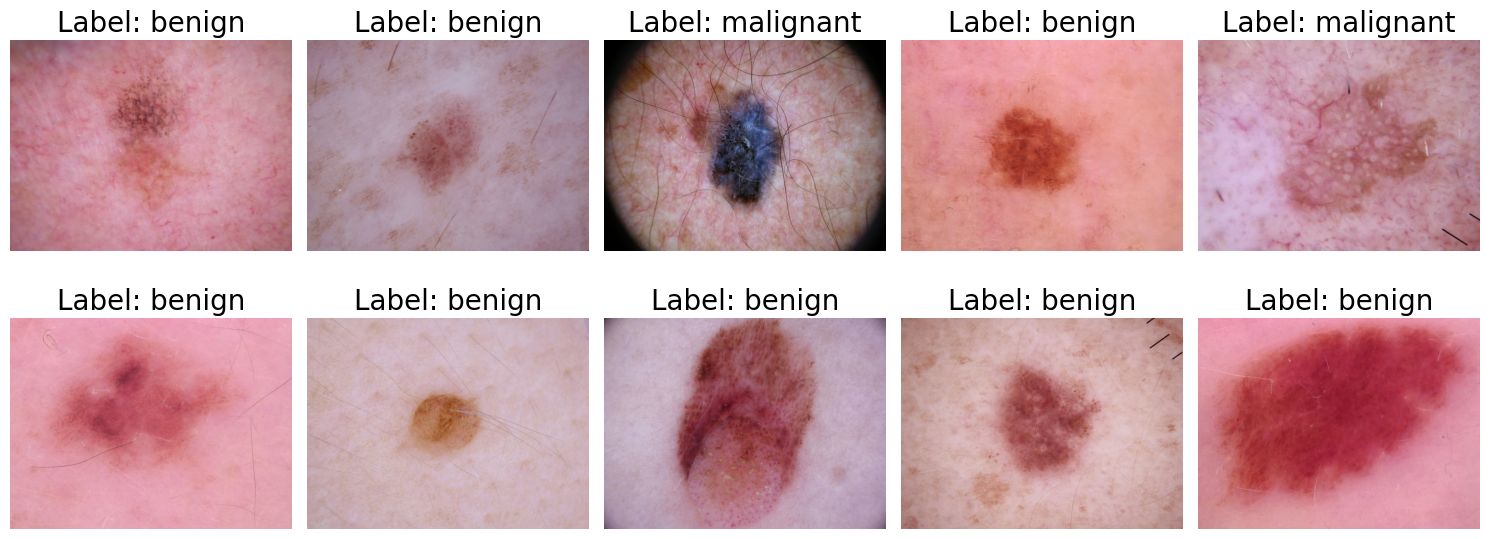

In [6]:
import matplotlib.pyplot as plt

# Select random indcies for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

# create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Loop through the random indices and display the images
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((600, 450))

    # Display images
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=20)

plt.tight_layout()
plt.show()

In [7]:
# Image Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)/255.0
    return image

# Load images and apply augmentation


def open_image(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(600, 450))
        img = augment_image(img)
        images.append(img)
    return np.array(images)

# Encoder labels (convert label names to integers)


def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)


# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_image(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [8]:
# Model Architectecture (600x450x3)
base_model = VGG16(input_shape=(600, 450, 3),
                   include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# Build Model
model = Sequential()
model.add(Input(shape=(600, 450, 3)))  # Input layer
model.add(base_model)  # VGG16 model
model.add(Flatten())  # Flatten layer
model.add(Dropout(0.3))  # Dropout layer

model.add(Dense(450, activation='relu'))  # Dense layer
model.add(Dropout(0.2))  # Dropout layer

model.add(Dense(len(os.listdir(train_dir)),
          activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# parameters
batch_size = 8
steps = int(len(train_paths) / batch_size)
epochs = 5


# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 17838s 18s/step - loss: 0.4627 - sparse_categorical_accuracy: 0.7954
Epoch 2/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 17061s 17s/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8070
Epoch 3/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 15700s 16s/step - loss: 0.3816 - sparse_categorical_accuracy: 0.8111
Epoch 4/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 15817s 16s/step - loss: 0.3773 - sparse_categorical_accuracy: 0.8067
Epoch 5/5
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 15745s 16s/step - loss: 0.3578 - sparse_categorical_accuracy: 0.8164


In [9]:
model.save('my_model.h5')

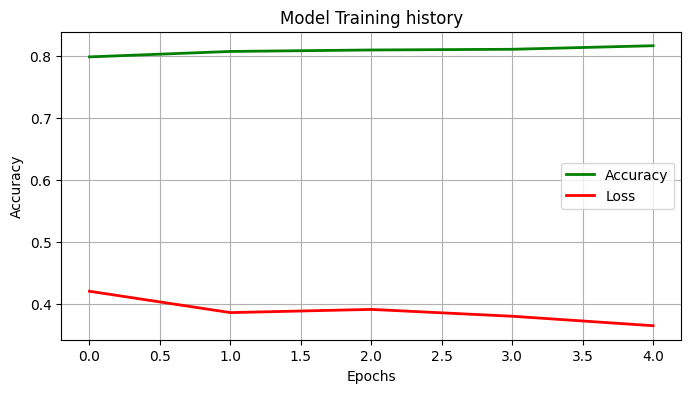

In [10]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', linewidth=2)
plt.plot(history.history['loss'], 'r-', linewidth=2)
plt.title('Model Training history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Loss'])
plt.show()

In [2]:
import os
print(os.path.exists('my_model.h5'))

True


In [2]:
from tensorflow.keras.models import load_model
model = load_model('my_model.h5')

In [3]:
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import random
import os

train_dir = '/Users/tejasbhavsar/PycharmProjects/PythonProject/data/train/'
test_dir = '/Users/tejasbhavsar/PycharmProjects/PythonProject/data/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []  # Initialize test_labels as an empty list
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)/255.0
    return image

# Load images and apply augmentation


def open_image(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(600, 450))
        img = augment_image(img)
        images.append(img)
    return np.array(images)

# Encoder labels (convert label names to integers)


def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


test_images = open_image(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report: ")
print(classification_report(test_labels_encoded,
      np.argmax(test_predictions, axis=1)))

: 

Confusion Matrix: 
[[ 179  212]
 [ 175 1437]]


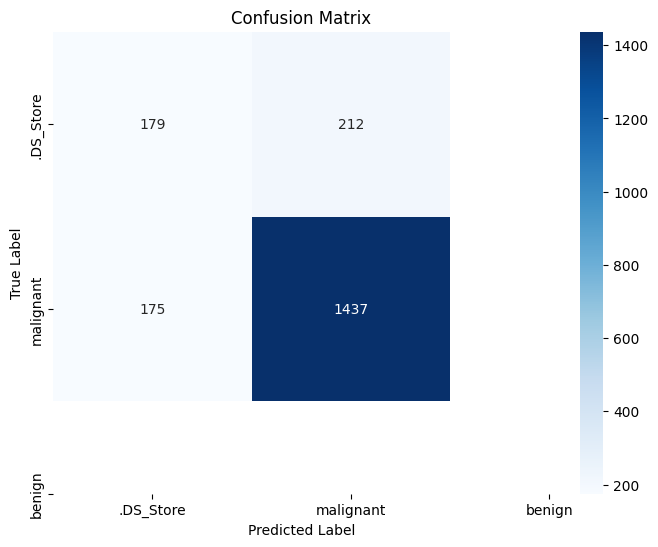

In [2]:
conf_matrix = confusion_matrix(
    test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix: ")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [1]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [2]:
model.save('another_model.h5')

/Users/tejasbhavsar/PycharmProjects/PythonProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


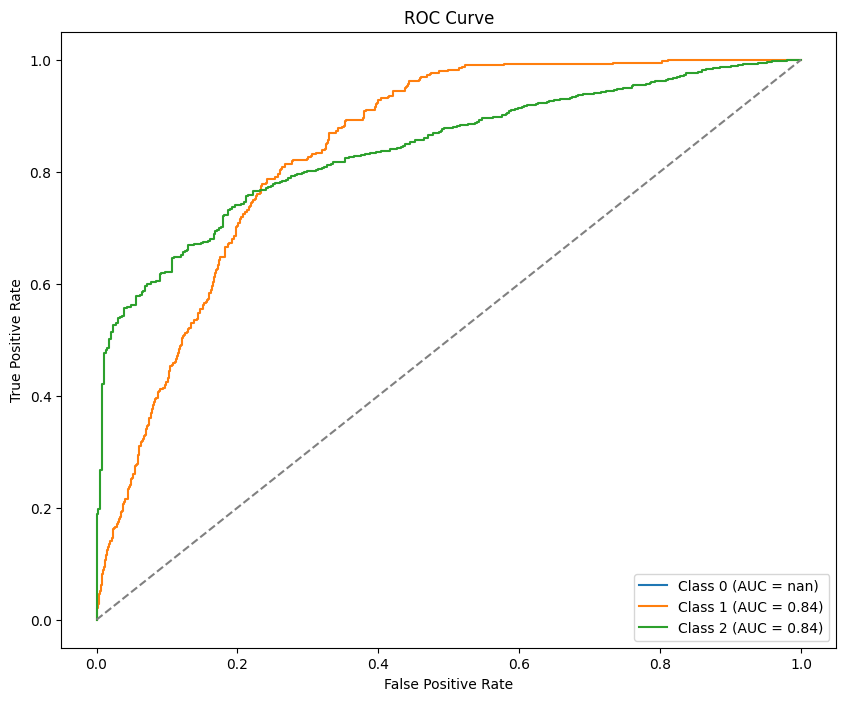

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

test_labels_bin = label_binarize(
    test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(
        test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [6]:
# save the model
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ['benign', 'malignant']


def detect_and_display(image_path, model):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(600, 450))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        if class_labels[predicted_class_index] == 'benign':
            result = 'Benign Tumor Detected'
        else:
            result = 'Malignant Tumor Detected'

        # Display the image and prediction
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence:) {confidence_score * 100:.2f}")
        plt.show()

    except Exception as e:
        print(f"Error processing image:", str(e))

In [1]:
import os
print(os.path.exists(
    '/Users/tejasbhavsar/PycharmProjects/PythonProject/data/test/benign/ISIC_0024370.jpg'))

True


In [2]:
image_path = '/Users/tejasbhavsar/PycharmProjects/PythonProject/data/test/benign/ISIC_0024370.jpg'
detect_and_display(image_path, model)

NameError: name 'detect_and_display' is not defined